In [63]:
# importan las librerias y el dataset a utilizar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import ScalarFormatter
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor 
import xgboost as xgb
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV

#cargamos el dataset
properati = pd.read_csv('C:/Users/ferna/Notebooks/PROYECTO FINAL DS/properati_dataset.csv')


In [43]:
def rfr_auto(X_train, y_train, X_test, y_test):
    '''
    Dado los conjuntos de Train y Test, genera un modelo de regresión Random Forest, entrena los datos y predice.
    A su vez, genera las metricas r2 y rmse.
    Por ultimo, grafica un histograma con el conteo de valores de error entre los valores predichos y los valores reales para el dataset
    de entrenamiento y el de testeo. Y un scatter plot que grafica la relación entre los valores predichos y 
    los valores reales
    Args:
    - X_train: dataset de variables predictoras de entrenamiento
    - y_train: dataset de variable target de entrenamiento
    - X_test: dataset de variables predictoras de test
    - y_test: dataset de variable target de test
    '''
        
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    y_train_pred_rfr = rfr.predict(X_train)
    y_test_pred_rfr = rfr.predict(X_test)
    
    r2_rfr_train = metrics.r2_score(y_train, y_train_pred_rfr)
    r2_rfr_test = metrics.r2_score(y_test, y_test_pred_rfr)
    rmse_rfr_train = np.sqrt(mean_squared_error(y_train, y_train_pred_rfr))
    rmse_rfr_test =  np.sqrt(mean_squared_error(y_test, y_test_pred_rfr))
    
    print('Modelo de regresión de Random Forest:')    
    print(f'Raíz del error cuadrático medio (RMSE) - Train: {round(rmse_rfr_train,3)}')
    print(f'Raíz del error cuadrático medio (RMSE) - Test : {round(rmse_rfr_test,3)}')
    print(f'Valor de R cuadrado (R-Squared) - Train : {round(r2_rfr_train,3)}')
    print(f'Valor de R cuadrado (R-Squared) - Test: {round(r2_rfr_test,3)}')
    print(f'Error Absoluto Medio (MAE)- Train: {round(mean_absolute_error(y_train,y_train_pred_rfr))}')
    print(f'Error Absoluto Medio (MAE) - Test: {round(mean_absolute_error(y_test,y_test_pred_rfr))}')
    print(f'Error Cuadrático Medio (MSE) - Train: {round(mean_squared_error(y_train, y_train_pred_rfr))}')
    print(f'Error Cuadrático Medio (MSE) - Test: {round(mean_squared_error(y_test, y_test_pred_rfr))}')
    
    plt.figure(figsize = (15,4))
    
    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred_rfr, bins = 20, label = 'train', color='blue', kde=True)
    sns.histplot(y_test - y_test_pred_rfr, bins = 20, label = 'test', color='red', kde=True)
    plt.xlabel('Errores')
    plt.legend()
    
    ax=plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_rfr, s =2)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, alpha=0.75, zorder=0, c='r')
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)');

## 3. Elección de algoritmo y optimización de hiperparámetros

Habiendo probado los algoritmos sobre el dataset completo, se obtuvo los mejores resultados de base con el Random Forest Regressor. Por lo que ahora, este modelo será utilizado sobre los dataset por cada tipo de propiedad (casa, ph y departamento).

In [44]:
properati

,Unnamed: 0,lat,lon,barrio,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,138,-34.630374,-58.707596,Ituzaingó,3,2,1,292,90,110000.0,Casa
1,252,-34.871555,-58.025476,La Plata,7,3,2,325,325,120000.0,Casa
2,319,-34.916178,-57.993599,La Plata,6,4,3,230,183,170000.0,Casa
3,384,-34.650923,-58.489653,Mataderos,3,2,1,171,120,179900.0,Casa
4,459,-34.822145,-58.479788,Esteban Echeverría,3,1,1,227,80,123000.0,Casa
...,...,...,...,...,...,...,...,...,...,...,...
73929,146652,-34.582228,-58.540320,General San Martín,2,1,1,38,38,70000.0,Departamento
73930,146655,-34.816348,-58.181963,Berazategui,2,1,1,54,48,165000.0,Departamento
73931,146657,-34.444633,-58.981606,Pilar,1,1,1,50,35,73000.0,Departamento
73932,146658,-34.444830,-58.981796,Pilar,2,1,1,38,38,68000.0,Departamento


In [45]:
properati = properati.drop("Unnamed: 0",axis=1)

Creación de X e y,para luego crear los datos de entrenamiento y prueba, y tratamiento de variables categóricas para cada tipo de propiedad

In [46]:
# se crea un dataset por cada tipo de propiedad
casa = properati[properati["property_type"]=="Casa"]
ph = properati[properati["property_type"]=="PH"]
dep = properati[properati["property_type"]=="Departamento"]

In [47]:
# se separan en sets de variables predictoras y variables target
X_casa = casa.drop(["price","property_type"], axis=1) 
y_casa = casa.price
X_ph = ph.drop(["price","property_type"], axis=1) 
y_ph = ph.price
X_dep = dep.drop(["price","property_type"], axis=1) 
y_dep = dep.price

In [48]:
# se convierten las variables categoricas en columnas por categoría
X_casa = pd.get_dummies(data=X_casa,prefix="barrio",columns=["barrio"],drop_first=True)
X_ph = pd.get_dummies(data=X_ph,prefix="barrio",columns=["barrio"],drop_first=True)
X_dep = pd.get_dummies(data=X_dep,prefix="barrio",columns=["barrio"],drop_first=True)

In [49]:
print("Cantidad de casas: ",X_casa.shape[0])
print("Cantidad de PH: ",X_ph.shape[0])
print("Cantidad de departamentos: ",X_dep.shape[0])

Cantidad de casas:  9126
Cantidad de PH:  8242
Cantidad de departamentos:  56566


#### Creación de sets de entrenamiento y prueba

Usamos el train test split para separar el 70/30 del dataset en entrenamiento y prueba, respectivamente

In [50]:
X_train_casa, X_test_casa, y_train_casa, y_test_casa = train_test_split(X_casa, y_casa, test_size=0.30, random_state=88) 
X_train_ph, X_test_ph, y_train_ph, y_test_ph = train_test_split(X_ph, y_ph, test_size=0.30, random_state=88) 
X_train_dep, X_test_dep, y_train_dep, y_test_dep = train_test_split(X_dep, y_dep, test_size=0.30, random_state=88) 

### Random Forest Regression

Utilizamos la función creada para utilizar el modelo para cada tipo de propiedad

#### Modelo RFR Casa

Modelo de regresión de Random Forest:
Raíz del error cuadrático medio (RMSE) - Train: 15876.529
Raíz del error cuadrático medio (RMSE) - Test : 41855.569
Valor de R cuadrado (R-Squared) - Train : 0.95
Valor de R cuadrado (R-Squared) - Test: 0.642
Error Absoluto Medio (MAE)- Train: 11462
Error Absoluto Medio (MAE) - Test: 29870
Error Cuadrático Medio (MSE) - Train: 252064175
Error Cuadrático Medio (MSE) - Test: 1751888636


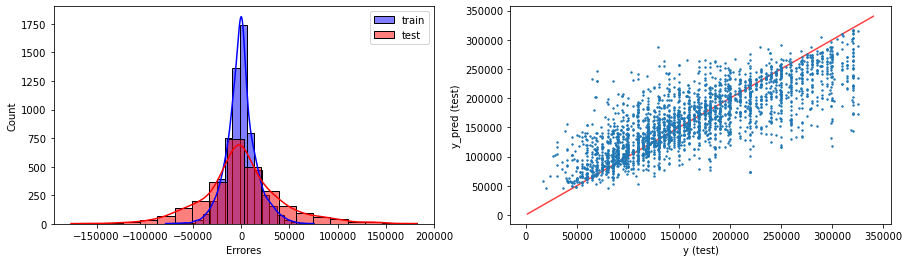

In [51]:
rfr_auto(X_train_casa, y_train_casa, X_test_casa, y_test_casa)

#### Modelo RFR PH

Modelo de regresión de Random Forest:
Raíz del error cuadrático medio (RMSE) - Train: 8866.015
Raíz del error cuadrático medio (RMSE) - Test : 21724.444
Valor de R cuadrado (R-Squared) - Train : 0.971
Valor de R cuadrado (R-Squared) - Test: 0.825
Error Absoluto Medio (MAE)- Train: 6040
Error Absoluto Medio (MAE) - Test: 14277
Error Cuadrático Medio (MSE) - Train: 78606219
Error Cuadrático Medio (MSE) - Test: 471951469


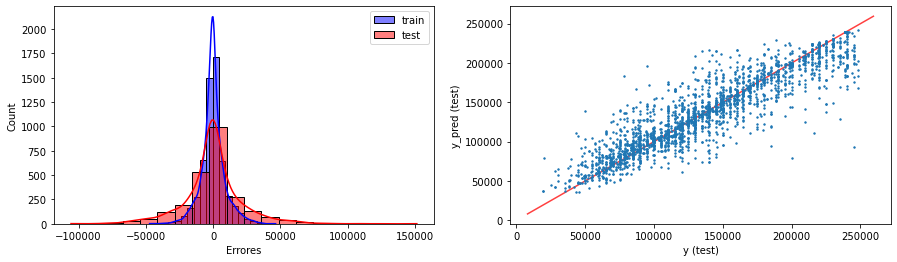

In [52]:
rfr_auto(X_train_ph, y_train_ph, X_test_ph, y_test_ph)

#### Modelo RFR Departamentos

Modelo de regresión de Random Forest:
Raíz del error cuadrático medio (RMSE) - Train: 7387.159
Raíz del error cuadrático medio (RMSE) - Test : 17404.154
Valor de R cuadrado (R-Squared) - Train : 0.978
Valor de R cuadrado (R-Squared) - Test: 0.879
Error Absoluto Medio (MAE)- Train: 4733
Error Absoluto Medio (MAE) - Test: 10691
Error Cuadrático Medio (MSE) - Train: 54570119
Error Cuadrático Medio (MSE) - Test: 302904577


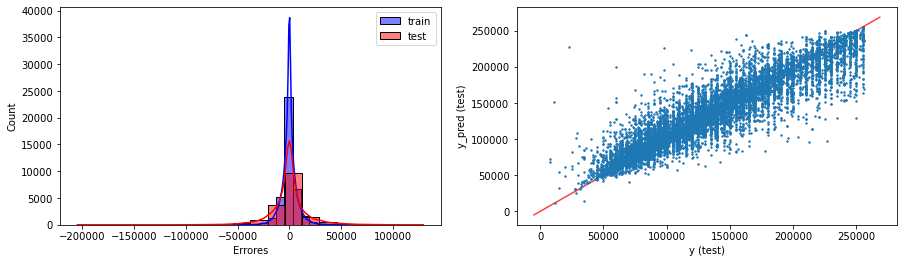

In [53]:
rfr_auto(X_train_dep, y_train_dep, X_test_dep, y_test_dep)

### XGBRegressor

Con el objetivo de probar una alternativa, en búsqueda de mejoras en las métricas (sobre todo para el caso de las casas), se decide evaluar el modelo XGB Regressor. Tambien se probará con los demás tipo de propiedad para ver que resultados obtenemos. Primero se evalua sin modificar los parámetros default

In [66]:
def xgbr_auto(X_train, y_train, X_test, y_test):
    '''
    Dado los conjuntos de Train y Test, genera un modelo de regresión Random Forest, entrena los datos y predice.
    A su vez, genera las metricas r2 y rmse.
    Por ultimo, grafica un histograma con el conteo de valores de error entre los valores predichos y los valores reales para el dataset
    de entrenamiento y el de testeo. Y un scatter plot que grafica la relación entre los valores predichos y 
    los valores reales
    Args:
    - X_train: dataset de variables predictoras de entrenamiento
    - y_train: dataset de variable target de entrenamiento
    - X_test: dataset de variables predictoras de test
    - y_test: dataset de variable target de test
    '''
        
    xgbr = xgb.XGBRegressor()
    xgbr.fit(X_train, y_train)
    y_train_pred_xgbr = xgbr.predict(X_train)
    y_test_pred_xgbr = xgbr.predict(X_test)
    
    r2_xgbr_train = metrics.r2_score(y_train, y_train_pred_xgbr)
    r2_xgbr_test = metrics.r2_score(y_test, y_test_pred_xgbr)
    rmse_xgbr_train = np.sqrt(mean_squared_error(y_train, y_train_pred_xgbr))
    rmse_xgbr_test =  np.sqrt(mean_squared_error(y_test, y_test_pred_xgbr))
    
    print('Modelo de regresión de XGB:')    
    print(f'Raíz del error cuadrático medio (RMSE) - Train: {round(rmse_xgbr_train,3)}')
    print(f'Raíz del error cuadrático medio (RMSE) - Test : {round(rmse_xgbr_test,3)}')
    print(f'Valor de R cuadrado (R-Squared) - Train : {round(r2_xgbr_train,3)}')
    print(f'Valor de R cuadrado (R-Squared) - Test: {round(r2_xgbr_test,3)}')
    print(f'Error Absoluto Medio (MAE)- Train: {round(mean_absolute_error(y_train,y_train_pred_xgbr))}')
    print(f'Error Absoluto Medio (MAE) - Test: {round(mean_absolute_error(y_test,y_test_pred_xgbr))}')
    print(f'Error Cuadrático Medio (MSE) - Train: {round(mean_squared_error(y_train, y_train_pred_xgbr))}')
    print(f'Error Cuadrático Medio (MSE) - Test: {round(mean_squared_error(y_test, y_test_pred_xgbr))}')
    
    plt.figure(figsize = (15,4))
    
    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred_xgbr, bins = 20, label = 'train', color='blue', kde=True)
    sns.histplot(y_test - y_test_pred_xgbr, bins = 20, label = 'test', color='red', kde=True)
    plt.xlabel('Errores')
    plt.legend()
    
    ax=plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred_xgbr, s =2)
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()])]
    ax.plot(lims, lims, alpha=0.75, zorder=0, c='r')
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)');

Utilizamos la función creada para utilizar el modelo para cada tipo de propiedad

#### Modelo XGBR Casa

Modelo de regresión de XGB:
Raíz del error cuadrático medio (RMSE) - Train: 24086.329
Raíz del error cuadrático medio (RMSE) - Test : 41348.068
Valor de R cuadrado (R-Squared) - Train : 0.885
Valor de R cuadrado (R-Squared) - Test: 0.651
Error Absoluto Medio (MAE)- Train: 17947
Error Absoluto Medio (MAE) - Test: 30447
Error Cuadrático Medio (MSE) - Train: 580151256
Error Cuadrático Medio (MSE) - Test: 1709662708


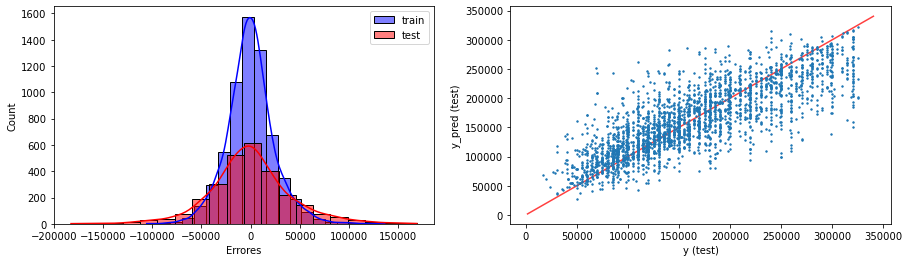

In [68]:
xgbr_auto(X_train_casa, y_train_casa, X_test_casa, y_test_casa)

In [ ]:
Observamos una leve mejora en las métricas de test para este tipo de propiedades.

#### Modelo XGBR PH

Modelo de regresión de XGB:
Raíz del error cuadrático medio (RMSE) - Train: 12750.727
Raíz del error cuadrático medio (RMSE) - Test : 23248.599
Valor de R cuadrado (R-Squared) - Train : 0.941
Valor de R cuadrado (R-Squared) - Test: 0.8
Error Absoluto Medio (MAE)- Train: 9105
Error Absoluto Medio (MAE) - Test: 15999
Error Cuadrático Medio (MSE) - Train: 162581038
Error Cuadrático Medio (MSE) - Test: 540497344


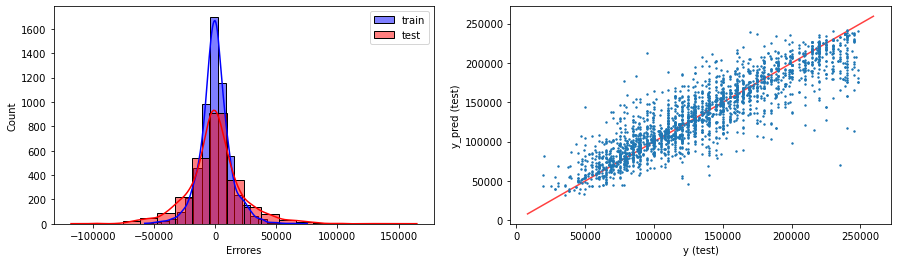

In [69]:
xgbr_auto(X_train_ph, y_train_ph, X_test_ph, y_test_ph)

#### Modelo XGBR Departamentos

Modelo de regresión de XGB:
Raíz del error cuadrático medio (RMSE) - Train: 18451.526
Raíz del error cuadrático medio (RMSE) - Test : 20872.251
Valor de R cuadrado (R-Squared) - Train : 0.864
Valor de R cuadrado (R-Squared) - Test: 0.826
Error Absoluto Medio (MAE)- Train: 13535
Error Absoluto Medio (MAE) - Test: 15064
Error Cuadrático Medio (MSE) - Train: 340458822
Error Cuadrático Medio (MSE) - Test: 435650878


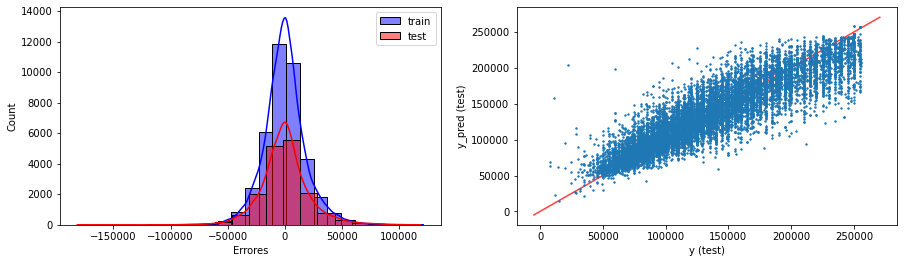

In [70]:
xgbr_auto(X_train_dep, y_train_dep, X_test_dep, y_test_dep)

Con los sets de departamentos y PH no se obtiene el mismo resultado, las métricas se encuentran por debajo del modelo de Random Forest.

De esta manera se da por finalizado el testing de los modelos y se concluye, que por tener mejor performance, los dataset de **Departamentos y PH** utilizarán el algoritmo **Random Forest Regressor** y para el dataset de **Casas** utilizaremos el algoritmo de boosting **XGBRegressor**.

## Optimización de los modelos

En esta sección se utilizará Randomized Search CV y Grid Search CV para mejorar los hiperparámetros, y para concluir se validará el modelo mediante Cross Validation

Para los 3 modelos se elige hacer algunas corridas de Randomized Search CV para saber en que valores enfocarnos para cada parámetro y luego utilizamos Grid Search CV para terminar de definir los valores, evitando generar corridas que requieran mucho tiempo de procesamiento.

### Dataset Casa

In [37]:
xgb_casa = xgb.XGBRegressor()
parameters = {'n_estimators': sp_randInt(100,1000),'subsample': sp_randFloat(),'eta': sp_randFloat(0.01,0.25),'max_depth': sp_randInt(4, 10)}

In [38]:
randm_src = RandomizedSearchCV(estimator=xgb_casa,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_casa,y_train_casa)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'eta': 0.03238295775377389, 'max_depth': 8, 'n_estimators': 984, 'subsample': 0.710631178982045}


In [39]:
randm_src = RandomizedSearchCV(estimator=xgb_casa, scoring='neg_root_mean_squared_error',param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_casa,y_train_casa)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'eta': 0.06210501410539462, 'max_depth': 9, 'n_estimators': 878, 'subsample': 0.5891292071933617}


In [40]:
randm_src = RandomizedSearchCV(estimator=xgb_casa, scoring='neg_root_mean_squared_error',param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_casa,y_train_casa)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'eta': 0.07943757269424405, 'max_depth': 7, 'n_estimators': 521, 'subsample': 0.8751051154091062}


In [41]:
randm_src = RandomizedSearchCV(estimator=xgb_casa, scoring='neg_root_mean_squared_error',param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_casa,y_train_casa)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'eta': 0.028298989337706408, 'max_depth': 6, 'n_estimators': 863, 'subsample': 0.7949402773422652}


In [42]:
randm_src = RandomizedSearchCV(estimator=xgb_casa, scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_casa,y_train_casa)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'eta': 0.0318720065674351, 'max_depth': 7, 'n_estimators': 727, 'subsample': 0.42413963614148875}


In [ ]:
parameters = [{'n_estimators': [500,550,600,650,700,750,800,850,900]}]
xgb_casa = xgb.XGBRegressor(max_depth=7,eta=0.06, subsample=0.7)

In [46]:
parameters = {'n_estimators': [550,600,650,700,750,800,850,900],'eta': [0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1],'subsample': [0.6,0.65,0.7,0.75,0.8],'max_depth':[6,7,8,9]}
xgb_casa = xgb.XGBRegressor()

In [47]:
gscv = GridSearchCV(xgb_casa,
                      param_grid=parameters,
                    scoring='neg_root_mean_squared_error',
                      cv=5)
gscv.fit(X_train_casa, y_train_casa)
gscv.best_params_

{'eta': 0.03, 'max_depth': 8, 'n_estimators': 900, 'subsample': 0.7}

In [48]:
parameters = [{'eta': [0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25]}]
xgb_casa = xgb.XGBRegressor(n_estimators=900,max_depth=8, subsample=0.75)
gscv = GridSearchCV(xgb_casa,
                      param_grid=parameters,
                    scoring='neg_root_mean_squared_error',
                      cv=5)
gscv.fit(X_train_casa, y_train_casa)
gscv.best_params_

{'eta': 0.05}

In [50]:
parameters = [{'subsample': [0.5,0.55,0.6,0.65,0.7,0.75,0.8]}]
xgb_casa = xgb.XGBRegressor(n_estimators=900,max_depth=8, eta=0.05)
gscv = GridSearchCV(xgb_casa,
                      param_grid=parameters,
                    scoring='neg_root_mean_squared_error',
                      cv=5)
gscv.fit(X_train_casa, y_train_casa)
gscv.best_params_

{'subsample': 0.8}

Modelo de regresión de XGB:
Raíz del error cuadrático medio (RMSE) - Train: 13495.74
Raíz del error cuadrático medio (RMSE) - Test : 38454.865
Valor de R cuadrado (R-Squared) - Train : 0.964
Valor de R cuadrado (R-Squared) - Test: 0.698
Error Absoluto Medio (MAE)- Train: 9994
Error Absoluto Medio (MAE) - Test: 27064
Error Cuadrático Medio (MSE) - Train: 182135011
Error Cuadrático Medio (MSE) - Test: 1478776674


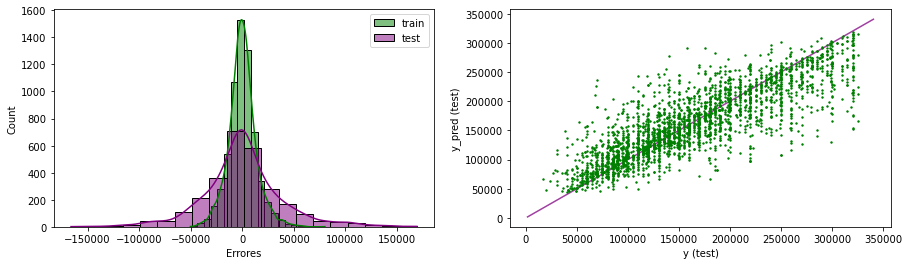

In [81]:
# Con los parámetros obtenidos se evalúa nuevamente el modelo
xgb_casa = xgb.XGBRegressor(n_estimators=900, max_depth=8, eta=0.03, subsample=0.7)
xgb_casa.fit(X_train_casa, y_train_casa)
y_train_pred_xgbr = xgb_casa.predict(X_train_casa)
y_test_pred_xgbr = xgb_casa.predict(X_test_casa)
    
r2_xgbr_train = metrics.r2_score(y_train_casa, y_train_pred_xgbr)
r2_xgbr_test = metrics.r2_score(y_test_casa, y_test_pred_xgbr)
rmse_xgbr_train = np.sqrt(mean_squared_error(y_train_casa, y_train_pred_xgbr))
rmse_xgbr_test =  np.sqrt(mean_squared_error(y_test_casa, y_test_pred_xgbr))
    
print('Modelo de regresión de XGB:')    
print(f'Raíz del error cuadrático medio (RMSE) - Train: {round(rmse_xgbr_train,3)}')
print(f'Raíz del error cuadrático medio (RMSE) - Test : {round(rmse_xgbr_test,3)}')
print(f'Valor de R cuadrado (R-Squared) - Train : {round(r2_xgbr_train,3)}')
print(f'Valor de R cuadrado (R-Squared) - Test: {round(r2_xgbr_test,3)}')
print(f'Error Absoluto Medio (MAE)- Train: {round(mean_absolute_error(y_train_casa,y_train_pred_xgbr))}')
print(f'Error Absoluto Medio (MAE) - Test: {round(mean_absolute_error(y_test_casa,y_test_pred_xgbr))}')
print(f'Error Cuadrático Medio (MSE) - Train: {round(mean_squared_error(y_train_casa, y_train_pred_xgbr))}')
print(f'Error Cuadrático Medio (MSE) - Test: {round(mean_squared_error(y_test_casa, y_test_pred_xgbr))}')

plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
sns.histplot(y_train_casa - y_train_pred_xgbr, bins = 20, label = 'train', color='green', kde=True)
sns.histplot(y_test_casa - y_test_pred_xgbr, bins = 20, label = 'test', color='purple', kde=True)
plt.xlabel('Errores')
plt.legend()

ax=plt.subplot(1,2,2)
ax.scatter(y_test_casa,y_test_pred_xgbr, s =2, c='g')
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, alpha=0.75, zorder=0, c='purple')
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)');

In [51]:
xgb_casa = xgb.XGBRegressor(n_estimators=900, max_depth=8, eta=0.03, subsample=0.8)
scores = cross_val_score(xgb_casa, X_train_casa, y_train_casa, cv=5, scoring='neg_root_mean_squared_error')
print(scores)

[-41344.7971623  -39158.94428987 -39955.23371686 -39801.65070493
 -40509.26965175]


Al final obtenemos un RMSE de aproximadamente $3000 más bajo que el que conseguimos sin ajustar los parámetros, esta es una mejora de casi el 10% en la predicción del algoritmo lo cual es realmente positivo teniendo en cuenta que en esta última etapa suele costar conseguir una mejora considerable en el modelo de machine learning y gracias al cross-validation vemos que nuestro modelo es consistente

Cabe aclarar que la gran diferencia de RMSE en el modelo de predicción de precio de casas con respecto a los otros dos modelos se debe a que el precio de las casas es mayor que los departamentos o PH

### Dataset PH

In [69]:
rf_ph = RandomForestRegressor()
parameters = {'n_estimators': sp_randInt(300,1000),'min_samples_split': sp_randInt(2, 6),'min_samples_leaf': sp_randInt(1,5),'max_depth':sp_randInt(80, 120)}

In [70]:
randm_src = RandomizedSearchCV(estimator=rf_ph,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_ph,y_train_ph)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 93, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 491}


In [71]:
randm_src = RandomizedSearchCV(estimator=rf_ph,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_ph,y_train_ph)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 87, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 687}


In [72]:
randm_src = RandomizedSearchCV(estimator=rf_ph,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_ph,y_train_ph)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 100, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 536}


In [73]:
randm_src = RandomizedSearchCV(estimator=rf_ph,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_ph,y_train_ph)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 96, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 689}


In [74]:
randm_src = RandomizedSearchCV(estimator=rf_ph,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_ph,y_train_ph)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 96, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 794}


In [76]:
parameters = {'n_estimators': [500,550,600,650,700,750,800],'min_samples_split': [2,3,4],'max_depth':[80,85,90,95,100,105]}
rf_ph = RandomForestRegressor()

In [77]:
gscv = GridSearchCV(rf_ph,
                      param_grid=parameters,
                    scoring='neg_root_mean_squared_error',
                      cv=5)
gscv.fit(X_train_ph, y_train_ph)
gscv.best_params_

{'max_depth': 85, 'min_samples_split': 2, 'n_estimators': 650}

Modelo de regresión de Random Forest:
Raíz del error cuadrático medio (RMSE) - Train: 8690.042
Raíz del error cuadrático medio (RMSE) - Test : 21669.615
Valor de R cuadrado (R-Squared) - Train : 0.972
Valor de R cuadrado (R-Squared) - Test: 0.826
Error Absoluto Medio (MAE)- Train: 5965
Error Absoluto Medio (MAE) - Test: 14215
Error Cuadrático Medio (MSE) - Train: 75516825
Error Cuadrático Medio (MSE) - Test: 469572203


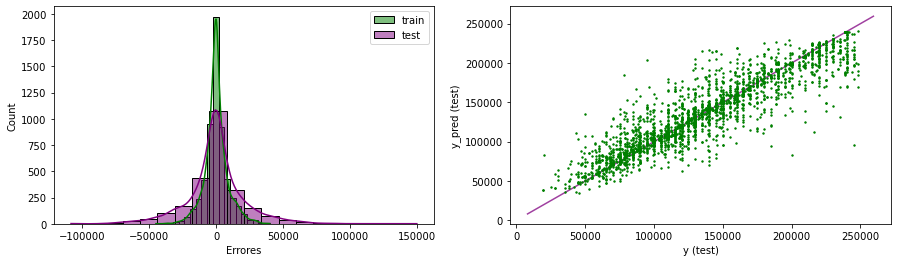

In [88]:
# Con los parámetros obtenidos se evalúa nuevamente el modelo
rf_ph = RandomForestRegressor(max_depth=85,n_estimators=650,min_samples_split=2)
rf_ph.fit(X_train_ph, y_train_ph)
y_train_pred_rfr = rf_ph.predict(X_train_ph)
y_test_pred_rfr = rf_ph.predict(X_test_ph)

r2_rfr_train = metrics.r2_score(y_train_ph, y_train_pred_rfr)
r2_rfr_test = metrics.r2_score(y_test_ph, y_test_pred_rfr)
rmse_rfr_train = np.sqrt(mean_squared_error(y_train_ph, y_train_pred_rfr))
rmse_rfr_test =  np.sqrt(mean_squared_error(y_test_ph, y_test_pred_rfr))

print('Modelo de regresión de Random Forest:')    
print(f'Raíz del error cuadrático medio (RMSE) - Train: {round(rmse_rfr_train,3)}')
print(f'Raíz del error cuadrático medio (RMSE) - Test : {round(rmse_rfr_test,3)}')
print(f'Valor de R cuadrado (R-Squared) - Train : {round(r2_rfr_train,3)}')
print(f'Valor de R cuadrado (R-Squared) - Test: {round(r2_rfr_test,3)}')
print(f'Error Absoluto Medio (MAE)- Train: {round(mean_absolute_error(y_train_ph,y_train_pred_rfr))}')
print(f'Error Absoluto Medio (MAE) - Test: {round(mean_absolute_error(y_test_ph,y_test_pred_rfr))}')
print(f'Error Cuadrático Medio (MSE) - Train: {round(mean_squared_error(y_train_ph, y_train_pred_rfr))}')
print(f'Error Cuadrático Medio (MSE) - Test: {round(mean_squared_error(y_test_ph, y_test_pred_rfr))}')

plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
sns.histplot(y_train_ph - y_train_pred_rfr, bins = 20, label = 'train', color='green', kde=True)
sns.histplot(y_test_ph - y_test_pred_rfr, bins = 20, label = 'test', color='purple', kde=True)
plt.xlabel('Errores')
plt.legend()
    
ax=plt.subplot(1,2,2)
ax.scatter(y_test_ph,y_test_pred_rfr, s =2, c='g')
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, alpha=0.75, zorder=0, c='purple')
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)');

In [95]:
rf_ph = RandomForestRegressor(n_estimators=650,max_depth=85,min_samples_split=2)
scores = cross_val_score(rf_ph, X_train_ph, y_train_ph, cv=5, scoring='neg_root_mean_squared_error')

In [96]:
scores

array([-22600.75000679, -24167.23117615, -22611.70570796, -24125.7873301 ,
       -23570.95812128])

### Dataset Departamentos

In [80]:
rf_dep = RandomForestRegressor()
parameters = {'n_estimators': sp_randInt(300,1000),'min_samples_split': sp_randInt(2, 6),'min_samples_leaf': sp_randInt(1,5),'max_depth':sp_randInt(80, 120)}

In [81]:
randm_src = RandomizedSearchCV(estimator=rf_dep,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_dep,y_train_dep)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 105, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 915}


In [82]:
randm_src = RandomizedSearchCV(estimator=rf_dep,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_dep,y_train_dep)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 118, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 668}


In [83]:
randm_src = RandomizedSearchCV(estimator=rf_dep,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_dep,y_train_dep)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 111, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 983}


In [84]:
randm_src = RandomizedSearchCV(estimator=rf_dep,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_dep,y_train_dep)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 104, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 897}


In [85]:
randm_src = RandomizedSearchCV(estimator=rf_dep,scoring='neg_root_mean_squared_error', param_distributions = parameters,cv = 2, n_iter = 20, n_jobs=-1)
randm_src.fit(X_train_dep,y_train_dep)
print("Mejores parámetros", randm_src.best_params_)

Mejores parámetros {'max_depth': 104, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 663}


In [89]:
parameters = {'n_estimators': [700,800,1000,900],'max_depth':[105,110,115,120,125]}
rf_dep = RandomForestRegressor()
gscv = GridSearchCV(rf_dep,
                      param_grid=parameters,
                    scoring='neg_root_mean_squared_error',
                      cv=5)
gscv.fit(X_train_dep, y_train_dep)
gscv.best_params_

{'max_depth': 125, 'n_estimators': 1000}

Modelo de regresión de Random Forest:
Raíz del error cuadrático medio (RMSE) - Train: 7271.687
Raíz del error cuadrático medio (RMSE) - Test : 17315.808
Valor de R cuadrado (R-Squared) - Train : 0.979
Valor de R cuadrado (R-Squared) - Test: 0.88
Error Absoluto Medio (MAE)- Train: 4675
Error Absoluto Medio (MAE) - Test: 10630
Error Cuadrático Medio (MSE) - Train: 52877429
Error Cuadrático Medio (MSE) - Test: 299837194


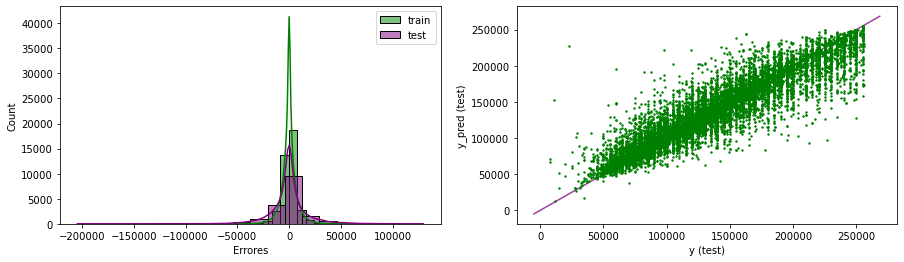

In [87]:
# Con los parámetros obtenidos se evalúa nuevamente el modelo
rf_dep = RandomForestRegressor(max_depth=125,n_estimators=1000,min_samples_split=2)
rf_dep.fit(X_train_dep, y_train_dep)
y_train_pred_rfr = rf_dep.predict(X_train_dep)
y_test_pred_rfr = rf_dep.predict(X_test_dep)

r2_rfr_train = metrics.r2_score(y_train_dep, y_train_pred_rfr)
r2_rfr_test = metrics.r2_score(y_test_dep, y_test_pred_rfr)
rmse_rfr_train = np.sqrt(mean_squared_error(y_train_dep, y_train_pred_rfr))
rmse_rfr_test =  np.sqrt(mean_squared_error(y_test_dep, y_test_pred_rfr))

print('Modelo de regresión de Random Forest:')    
print(f'Raíz del error cuadrático medio (RMSE) - Train: {round(rmse_rfr_train,3)}')
print(f'Raíz del error cuadrático medio (RMSE) - Test : {round(rmse_rfr_test,3)}')
print(f'Valor de R cuadrado (R-Squared) - Train : {round(r2_rfr_train,3)}')
print(f'Valor de R cuadrado (R-Squared) - Test: {round(r2_rfr_test,3)}')
print(f'Error Absoluto Medio (MAE)- Train: {round(mean_absolute_error(y_train_dep,y_train_pred_rfr))}')
print(f'Error Absoluto Medio (MAE) - Test: {round(mean_absolute_error(y_test_dep,y_test_pred_rfr))}')
print(f'Error Cuadrático Medio (MSE) - Train: {round(mean_squared_error(y_train_dep, y_train_pred_rfr))}')
print(f'Error Cuadrático Medio (MSE) - Test: {round(mean_squared_error(y_test_dep, y_test_pred_rfr))}')

plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
sns.histplot(y_train_dep - y_train_pred_rfr, bins = 20, label = 'train', color='green', kde=True)
sns.histplot(y_test_dep - y_test_pred_rfr, bins = 20, label = 'test', color='purple', kde=True)
plt.xlabel('Errores')
plt.legend()
    
ax=plt.subplot(1,2,2)
ax.scatter(y_test_dep,y_test_pred_rfr, s =2, c='g')
lims = [np.min([ax.get_xlim(), ax.get_ylim()]),  
np.max([ax.get_xlim(), ax.get_ylim()])]
ax.plot(lims, lims, alpha=0.75, zorder=0, c='purple')
plt.xlabel('y (test)')
plt.ylabel('y_pred (test)');

In [91]:
rf_dep = RandomForestRegressor(max_depth=125,n_estimators=1000,min_samples_split=2)
scores = cross_val_score(rf_dep, X_train_dep, y_train_dep, cv=5, scoring='neg_root_mean_squared_error')

In [92]:
scores

array([-18386.40337156, -18225.38003849, -18022.35382608, -17681.70216542,
       -18046.01218418])

En ambos modelos de Random Forest se obtienen pequeñas mejoras comparando con los resultados obtenidos con los parámetros por defecto, tal vez se podría mejorar un poco más pero llevaría muchas horas de procesamiento, teniendo en cuenta que correr las funciones para mejora de hiperparámetros pueden tardar varias horas con solo un puñado de parámetros y valores a evaluar

Por último, con la optimización de parámetros obtenemos resultados un poco mejores a los de las métricas con los parámetros por defecto, viendo los resultados del cross validation notamos que nuestros modelos son consistentes y están dentro de lo aceptable.

### Conclusión

Como punto de partida en la sección de data wrangling, a medida que se iba obteniendo información por el procesamiento del dataset, se comienza a entender como debian tratarse los datos para poder utilizarlos en un modelo posteriormente. El dataset contenía una gran cantidad de outliers y una concentración muy marcada en tres tipos de propiedades, conteniendo alrededor del 90% de los datos por lo que se decidió trabajar con esos tres tipos de propiedades unicamente. Así, es como se buscó dejar todos los campos del dataset lo más consistentes posible. 

Luego, con el inicio de las pruebas de modelos candidatos de machine learning, surgió la alternativa de que lo mas adecuado era tener un modelo por cada tipo de propiedad escogido, ya que esto se reflejaba en los resultados y, a su vez, se encontraba una gran desproporción entre las categorías. En caso de haber hecho un solo modelo es probable que se hubiese necesitad realizar un procedimiento para balancear la cantidad de datos de cada clase.

Llegando al final del proyecto nos enfrentamos con la optimización de parámetros de los modelos, que fue la primera y única parte del proyecto donde vimos como puede afectar la capacidad de computo en el mismo, ya que tanto GridSearchCV como RandomizedSearchCV podían tardar horas e incluso días si no estableciamos un límite en las ejecuciones que hacen dichas funciones. En esta última instancia, se cometió el error de probar cada parámetro por separado, sin considerar que no solo cada parámetro por si mismo afecta la performance del modelo, sino tambien en su conjunto, es por esto, que se volvió a realizar de tal manera en la que evaluara los parámetros más importantes juntos pero a la vez teniendo en cuenta que no tenía que tardar un tiempo excesivamente largo en ejecutar las funciones. Por lo tanto acotó los posibles valores de cada parámetro. Habiendo utilizado 2 tipos de modelo distintos notamos que hay modelos que pueden tener una mejora más notoria en la fase de optimización que otros, teniendo la precaución de que esto no genere un overfitting. De todas maneras, lo más común es que la optimización de los hiperparámetros tenga efectos pequeños porque llegado a este punto del proyecto mejoras significativas tienen un costo computacional muy alto.  

A modo de cierre, dejamos una serie de posibles mejoras/adiciones que se podría mejorar aún mas los resultados obtenidos:

- Hacer más modelos para las categorías que quedaron afuera consiguiendo más registros que los que tenía el dataset original
- Se podría considerar separar modelos para discriminar las casas/ph/departamentos en función de la ubicación de las propiedades (zona o barrios de Buenos Aires)
- Probar un modelo de regresión hecho con redes neuronales
- Con el dataset también se podría hacer un modelo de predicción de tipo de propiedad para saber si una propiedad es una casa, departamento o ph.